In [17]:
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
from array2gif import write_gif

plt.style.use('ggplot')

mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


#### Instantiate VAE and Saver

In [8]:
vae = VAE(beta=1,batch_size=1000,learning_rate=1e-4,network_type='fully_connected',latent_dim=2)
saver = tf.train.Saver()

#### Training

In [9]:
def draw_digits_latent_space(z_mean_test, test_label):
    plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
    plt.colorbar()
    plt.show()

In [10]:
# Initialization
list_of_latent_spaces = []
list_of_z_mu = []

hm_epochs = 1000

# for plotting latent space every 50 epochs
MM = vae.batch_size
grid_max = 100.0
z_test1 = np.linspace(grid_max,-grid_max,MM)
z_test2 = np.linspace(grid_max,-grid_max,MM)
zz = np.array([z_test1,z_test2])
zz = np.transpose(zz)

history_loss = []
history_recon = []
history_kl = []
epoch_loss = 0
recon_loss = 0
kl_loss = 0


Epoch 1 / 1000 ; average loss: 120134.2880356519; Reconstruction loss :  119865.46948224436; KL loss 268.81853842812393


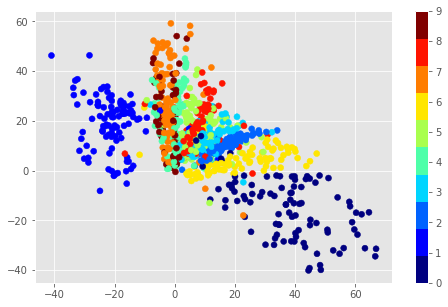

KeyboardInterrupt: 

In [23]:
for epoch in range(hm_epochs):

    for _ in range(int(mnist.train.num_examples/vae.batch_size)):
        epoch_x, epoch_label = mnist.train.next_batch(vae.batch_size)
        epoch_label = np.argmax(epoch_label,axis=1)
        _, c, recon, kl = vae.fit(np.rint(epoch_x).astype(np.float32))
        epoch_loss += c/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        recon_loss += recon/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        kl_loss += kl/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        history_loss.append(epoch_loss)
        history_recon.append(recon_loss)
        history_kl.append(kl_loss)
        
    if epoch % 10 is 0:
        print('Epoch', epoch+1, '/',hm_epochs,'; average loss:',epoch_loss, end='; ')
        print('Reconstruction loss : ', recon_loss, end='; ')
        print('KL loss', kl_loss)
        
#         z_mu = vae.get_z_mean(np.rint(epoch_x).astype(np.float32))
#         list_of_z_mu.append(z_mu)
#         plt.close()
#         plt.figure(figsize=(8, 5))
#         draw_digits_latent_space(z_mu, epoch_label)
#         plt.show()

In [21]:
write_gif(list_of_z_mu, 'mnist.gif', fps=5)


ValueError: Each image needs 3 dimensions: rgb, nrows, ncols
At position 0 in the list of arrays.

#### Only use this section if saving model

In [89]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'saved_models/vae-fc-'
saved_filename = filename+timestr
saver.save(vae.sess,filename+timestr)

'saved_models/vae-fc-20181029-171037'

#### Restoring model weights

In [90]:
saver.restore(vae.sess, 'saved_models/vae-fc-20181029-171037')

INFO:tensorflow:Restoring parameters from saved_models/vae-fc-20181029-171037


#### Visualise data reconstruction

In [110]:
test_epoch, _ = mnist.train.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))

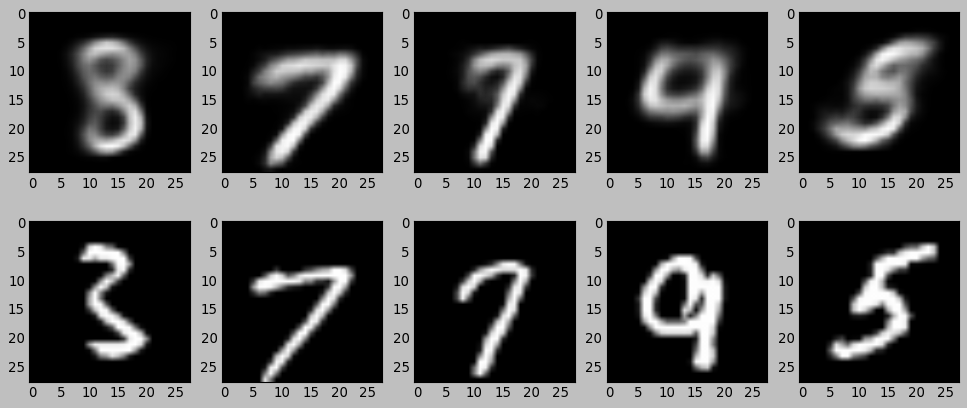

In [111]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()
n = 0
j = 0

for i in range(n,n+5):
    axs[j].imshow(x_tst[i,:].reshape([28,28]),cmap='gray')
    axs[j+5].imshow(test_epoch[i,:].reshape([28,28]),cmap='gray')
    j += 1
    
plt.show()

#### Visualise latent space

In [84]:
test_epoch, test_label = mnist.train.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))
test_label = np.argmax(test_label,axis=1)

In [85]:
z_mean_test = vae.sess.run(vae.z_mu, {vae.x: x_tst})

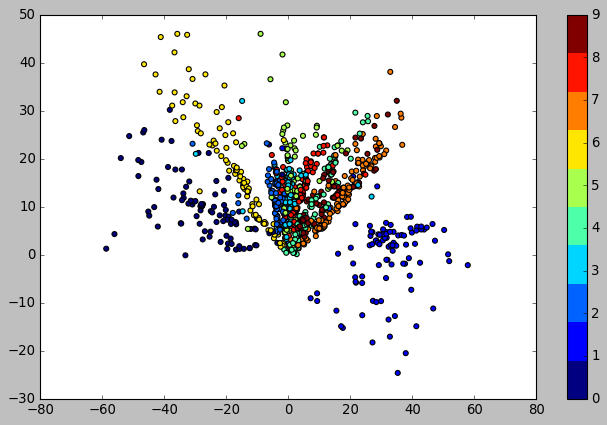

In [116]:
plt.figure(figsize=(10, 6))
plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.show()

In [98]:
from sklearn import decomposition

In [100]:
pca = decomposition.PCA(n_components=2)
pca.fit(z_mean_test)
z_pca = pca.transform(z_mean_test)

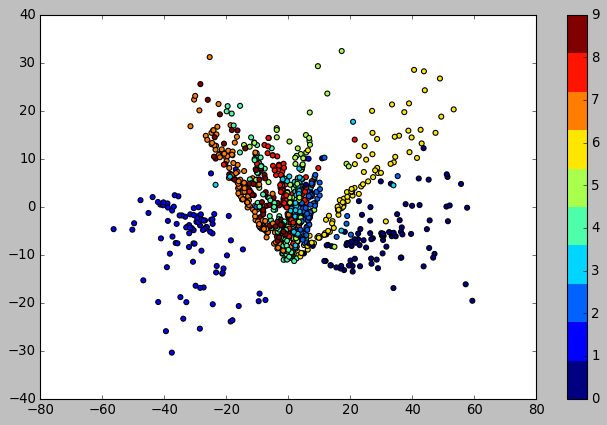

In [101]:
plt.figure(figsize=(10, 6))
plt.scatter(z_pca[:,0],z_pca[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.show()